<a href="https://colab.research.google.com/github/lphansen/RiskUncertaintyValue/blob/main/shockelasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shock Elasticity Computation

Shock elasticities quantify the (local) exposures of macroeconomic cash flows to shocks over alternative investment horizons and the corresponding prices or investors’ compensations. This Jupyter notebook provides the computations for the shock elasticities for models that are exponential-quadratic.   This model structure is particularly tractable with quasi-analytical solutions. This notebook implements methods and formulas developed in [2] and [3].    
- Section 1 introduces the exponential–quadratic framework. It supposes this structure emerges as an approximation with the approximation taken as input into the computer code.  
- Section 2 presents shock elasticity formulas for both exposure and price elasticities.
- Section 3 provides an illustration using the long-run risk model [1].




# 1. Exponential-linear-quadratic Framework

We suppose a linear-quadratic specification of the state dynamics:

$$
\begin{aligned}
X_{t}^0&= \bar{x}\\
X_{t+1}^1&=\Theta_{10}^x+\Theta_{11}^x X_{t}^1+\Sigma_{10}^x W_{t+1}\\
X_{t+1}^2&= \Theta_{20}^x+\Theta_{21}^x X_{t}^1+\Theta_{22}^xX_{t}^2+\Theta_{23}^x\left(X_{t}^1 \otimes X_{t}^1\right) +\Sigma_{20}^x W_{t+1}+\Sigma_{21}^x\left(X_{t}^1 \otimes W_{t+1}\right) +\Sigma_{22}^x\left(W_{t+1} \otimes W_{t+1}\right) .
\end{aligned}\tag{1}
$$
The code will take the coefficients as inputs.

One way to construct such a system is to consider a family of the dynamic systems 
$$
X_{t+1}(\sf{q})=\psi \left[X_t(\sf{q}), \sf{q} W_{t+1}, \sf{q}\right]
$$
parameterized by $\sf q$. Following [4], we calculate a second-order approximation of stochastic processes
around the ``small noise'' limit ${\sf q} = 0$:
$$
X_t(\mathrm {q}) \approx X_{0, t}+ {\sf q} X_{1, t}+\frac{{\sf q}^2}{2} X_{2, t}
$$
where $X_{t}^m$ is the date $t$, $m^{th}$-order derivatitve approximation. This gives a version of the system (1) where 
\begin{aligned}
\bar{x} = &\  \psi(\bar x, 0, 0 ) \\
\Theta_{11}^x = &\  \psi_1 \\
\Sigma_{10}^x = &\  \psi_2\\
\Theta_{10}^x = &\  \psi_3 
\end{aligned}
and $\psi_i$ is the derivative of $\psi$ with respect to argument $i$ evaluated at $(\bar x, 0, 0).$  There are analogous formulas for the remaining matrices.  

For the purposes of the code we take the dynamic state evolution as a starting point with state vector 
$$
X_t = \begin{bmatrix} X_{t}^0 \cr X_{t}^1 \cr X_{t}^2 \end{bmatrix}. 
$$
as the Markov state with evolution

We suppose that the logarithms of macroeconomic and stochastic discount factor processes that interest us grow or decay stochastically over time with stationary increments.  Let $Y$ be the logarithm of such a process. The process $Y$ will display linear growth or decay. We refer to its exponential $M = \exp(Y)$ as a multiplicative process.  We use multiplicative processes to capture growth or decay in levels. We presume that
$$
Y_{t+1} - Y_t = \Theta_0^y + \Theta_{1}^y X_{1,t} + \Theta_{2}^y X_{2,t} + \left( X_{1,t} \right)' \Theta_{3}^y X_{1,t} + \Sigma_0^y W_{t+1} + \left(X_{1,t} \right)' \Sigma_1^y W_{t+1} + \left( W_{t+1} \right)' \Sigma_2^y W_{t+1} \tag{2}
$$


Again we could derive this by embedding the $Y$ process in a parameterized family of processes with increments given by
$$
Y_{t+1}(\sf q)-Y_t({\sf q})=\kappa\left[X_t({\sf q}), {\sf q} W_{t+1}, {\sf q}\right]
$$
We approximate the resulting processes as:
$$
Y_{t+1}(\mathrm q)-Y_t({\sf q}) \approx Y_{t+1}^0-Y_{t}^0+ {\sf q} (Y_{t+1}^1 -Y_{t}^1)+\frac{{\sf q}^2}{2} (Y_{t+1}^2-Y_{t}^2)
$$
Following the steps of our approximation of $X$, we write
$$
\begin{aligned} 
\Theta_0^y &=  \kappa\left({\bar x},0,0 \right) & \Sigma_0^y &=  \kappa_2  \\
\Theta_1^y &=  \kappa_1 & \Sigma_1^y &=  \kappa_{12} \\
\Theta_2^y &=  \kappa_{1} & \Sigma_2^y &=  \frac 1 2 \kappa_{22} \\ 
\Theta_3^y &=   \frac 1 2 \kappa_{1,1}  &  &
\end{aligned}
$$
where $\kappa_i$ is the derivative of $\kappa$ with respect to argument $i$ evaluated at $(\bar x, 0, 0)$ and similarly for the second derivatives.  We set ${\sf q} = 1$.  

In what follows, $M$ will be a macro growth process, a stochastic discount factor process, or a product of the two. The user inputs are the quadratic specifications in equation (1) and equation (2).  

In [1]:
import os
import sys
workdir = os.getcwd()
# !git clone https://github.com/lphansen/RiskUncertaintyValue # Please uncomment this line when running on the google colab
# workdir = os.getcwd() + '/RiskUncertaintyValue'             # Please uncomment this line when running on the google colab
sys.path.insert(0, workdir+'/src')
from IPython.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))
import numpy as np
np.set_printoptions(suppress=True)
from scipy.stats import norm
from numba import njit, prange

from lin_quad import LinQuadVar
from lin_quad_util import next_period, log_E_exp, kron_prod, distance
from utilities import mat, vec, sym
from elasticity import exposure_elasticity, price_elasticity

"""
Python object 'LinQuadVar' stores the coefficients of a variable that has the linear-quadratic structure as shown in equations (1) and (2).
Below is an example of constructing a variable using the 'LinQuadVar'.
"""

n_Y = 1 # The dimension of the LinQuadVar, here we construct a one dimensional (scalar) LinQuadVar
n_X = 2 # The dimension of state variables, X_t
n_W = 4 # The dimension of shocks, W_t
lq = LinQuadVar({'c': np.array([[0.0015]]),                                         # The constant term
                'x': np.array([[1., 0.]]),                                          # The coefficients on X_{1,t}
                'w': np.array([[0., 0., 0.0078, 0.  ]]),                            # The coefficients on W_{t+1}
                'x2': np.array([[0.5, 0.]]),                                        # The coefficients on X_{2,t}
                'xw': np.array([[0.,  0.,  0.,  0.,  0.,  0., 0.0039, 0.]])},       # The coefficients on X_{1, t} \otimes W_{t+1}
                shape = (n_Y, n_X, n_W))                                            # The dimensions of LinQuadVar, X_t, and, W_t

## Display the coefficients of the LinQuadVar
lq.coeffs

{'c': array([[0.0015]]),
 'x': array([[1., 0.]]),
 'w': array([[0.    , 0.    , 0.0078, 0.    ]]),
 'x2': array([[0.5, 0. ]]),
 'xw': array([[0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0039, 0.    ]])}

# 2. Shock Elasticity
## 2.1 Analytical framework
Shock elasticities are used to quantify the date $t$ impact on values of exposure to the shock $
(\alpha_0 + \alpha_1 X_0) \cdot W_1$ at date one. It has the form shown in equation 3:
$$
\varepsilon( x, t)=   \frac{(\alpha_0 + \alpha_1 x) \cdot {\mathbb E}\left[\left( \frac {M_t}{M_0}\right) W_1 \mid X_0 = x\right]}{{\mathbb E} \left(\frac {M_t}{M_0}  \mid X_0 = x\right)}\tag{3}
$$

Using the linear-quadratic dynamics of section 1, the computer software computes the logarithm of the denominator of formula (3): 
$$
\log {\mathbb E}\left(\frac {M_t}{M_1}  \mid X_1 =x\right) = \Phi_{0, t}^*+\Phi_{1, t}^* x_1 +\Phi_{2, t}^*x_2 +
{\frac 1 2} (x_1)' \Phi_{3, t}^*x_1 \tag{4}
$$
recursively. Form
$$
{\mathbb M} \left[ \Phi_{0} +\Phi_1 x_1+\Phi_2 x_2 + {\frac 1 2} (x_1)'\Phi_3 x_1\right] \equiv
\log {\mathbb E} \left[\left( \frac {M_2}{M_1}\right)\exp\left[\Phi_{0} +\Phi_1 x_1+\Phi_2 x_2 + {\frac 1 2} (x_1)'\Phi_3 x_1\right] \mid X_0 = x \right]  
$$
Conveniently, we can express the outcomes as:
$$
{\mathbb M} \left[ \Phi_{0} +\Phi_1 x_1+\Phi_2 x_2 + {\frac 1 2} (x_1)'\Phi_3 x_1\right] =
{\widetilde \Phi}_{0} + {\widetilde \Phi}_1 x_1+ {\widetilde \Phi}_2 x_2 + {\frac 1 2} (x_1)'{\widetilde \Phi}_3 x_1
$$
for some specification of ${\widetilde \Phi}_i$, $i=0,1,2,3$. In words, the ${\mathbb M}$ operator maps linear-quadratic functions into linear-quadratic functions.  The code uses this mapping repeatedly.   

By a direct application of the Law of Iterated Expectations we have that
$$
\log {\mathbb E}\left(\frac {M_t}{M_1}  \mid X_1 =x\right) = {\mathbb M}^{t-1}[1]
$$
where ${\mathbb M}^{t-1}[1]$ means to apply the operator ${\mathbb M}$ $t-1$ times in succession to a function that is identically one.  Observe that ${\mathbb M}^{t-1}[1]$ is a function of $x$.  

The function *_Φ_star* defined below calculates the linear-quadratic dynamic coefficients in $\mathbb{M}$ mappings and iterations.

To complete the calculation of the elasticity, 
note that 
$$\frac{{\mathbb E}\left[\left(\frac { M_t}{M_0}\right)  W_1 \mid X_0=x\right]}{{\mathbb E}\left[\left(\frac {M_t}{M_0}\right)  \mid X_0=x\right]}=
\frac{{\mathbb E}\left[ \left(\frac {M_1}{M_0}\right)  {\mathbb E}\left(\frac{M_t}{M_1} \mid X_1\right) W_1 \mid X_0=x\right]}{{\mathbb E}\left[\left(\frac {M_1}{M_0}\right)  E\left(\frac{M_t}{M_1} \mid X_1\right) \mid X_0=x\right]} .$$
This leads us to construct the nonegative random variable:
$$L_{t}\equiv\frac{\left(\frac {M_1}{M_0}\right) \exp\left[ {\mathbb M}^{t-1}[1](X_1) \right]}{{\mathbb E}\left[\left(\frac {M_1}{M_0}\right) \exp\left[ {\mathbb M}^{t-1}[1](X_1) \right]
 \mid X_0=x\right]}\tag{5}$$
Notice that $L_{t}$ depends only date one information and has expectation one conditioned on date zero information. Multiplying this positive random
variable by $W_1$ and taking expectations is equivalent to changing the conditional probability distribution and evaluating the conditional expectation of $W_1$ under this change of measure. Since $W_1$ is normally distributed, the exponential quadratic construction of $L_{t}$ implies that $W_1$ remains normally distributed but with a different mean and covariance matrix.  The computer codes use this observation to evaluate formula (5) by taking an altered conditional expectation of $W_1$.  The derivation details to compute the conditional moments under the change of probability measure implied by $L_t$  can be found in [2], Appendix B, and [3], Appendix A.

For the purposes of the code, denote the conditional mean induced by $L_{t}$ as $\mu_{t}^0 + \mu_{t}^1 x_1$ and the conditional covariance matrix ${\widetilde \Sigma}_t$.



In [2]:
def _Φ_star(log_M_growth, X1_tp1, X2_tp1, T):
    r"""
    Computes :math:`\Phi^*_{0,t-1}`, :math:`\Phi^*_{1,t-1}`, :math:`\Phi^*_{2,t-1}`, :math:`\Phi^*_{3,t-1}` in equation (4).

    Parameters
    ----------
    log_M_growth : LinQuadVar
        Log growth of multiplicative functional M.
        e.g. log consumption growth, :math:`\log \frac{C_{t+1}}{C_t}`
    X1_tp1 : LinQuadVar
        Stores the coefficients of laws of motion for X1.
    X2_tp2 : LinQuadVar or None
        Stores the coefficients of laws of motion for X2.
    T : int
        Time horizon.

    Returns
    -------
    Φ_star_1tm1_all : (T, 1, n_X) ndarray
    Φ_star_2tm1_all : (T, 1, n_X) ndarray
    Φ_star_3tm1_all : (T, 1, n_X**2) ndarray

    """
    _, n_X, _ = X1_tp1.shape
    
    Φ_star_1tm1_all = np.zeros((T, 1, n_X))
    Φ_star_2tm1_all = np.zeros((T, 1, n_X))
    Φ_star_3tm1_all = np.zeros((T, 1, n_X**2))
    log_M_growth_distort = log_E_exp(log_M_growth)
    X1X1 = kron_prod(X1_tp1, X1_tp1)

    for i in range(1, T):
        Φ_star_1tm1_all[i] = log_M_growth_distort['x']
        Φ_star_2tm1_all[i] = log_M_growth_distort['x2']
        Φ_star_3tm1_all[i] = log_M_growth_distort['xx']
        temp = next_period(log_M_growth_distort, X1_tp1, X2_tp1, X1X1)
        log_M_growth_distort = log_E_exp(log_M_growth + temp)

    return Φ_star_1tm1_all, Φ_star_2tm1_all, Φ_star_3tm1_all

## 2.2 Limiting Behavior

The operator ${\mathbb M}$ typically has a solution to the following equation:
$$
{\mathbb M} \left[\Phi_1^e x_1+\Phi_2^e x_2 + {\frac 1 2} (x_1)'\Phi_3^e x_1\right] 
= 
\eta^e + 
{\mathbb M} \left[ \Phi_1^e x_1+\Phi_2^e x_2 + {\frac 1 2} (x_1)'\Phi_3^e x_1\right] \tag{6} 
$$

**[HH: one M shouldn't be here]**

The solution of interest when, it exists, can be deduced by iterating on the ${\mathbb M}$ operator allowing for a constant shift $\eta^e$.  This solution gives a characterization of the limiting elasticity.  Construct
$$
L_{1,\infty} = \left(\frac {M_1}{M_0} \right)\left(\frac{\exp\left[ \Phi_{0}^e +\Phi_1^e X_{1,1} +\Phi_2^e X_{2,1} + {\frac 1 2} (X_{1,1})'\Phi_3^e X_{1,1} \right]}{ 
\exp(\eta) \exp\left[ \Phi_{0}^e +\Phi_1^e X_{1,0} +\Phi_2^e X_{2,0} + {\frac 1 2} (X_{1,0})'\Phi_3^e X_{1,0}\right]} \right) . 
$$
The elasticities are given by conditional linear combinations of conditional expectations of $W_1$ under this limiting change of measure.

To express the equation of interest differently, consider the operator, ${\mathbb P}$ that maps $\Phi_{0} +\Phi_1 x_1+\Phi_2 x_2 + {\frac 1 2} (x_1)'\Phi_3 x_1$ into $\exp\left({\mathbb M} \left[ \Phi_{0} +\Phi_1^e x_1+\Phi_2 x_2 + {\frac 1 2} (x_1)'\Phi_3 x_1\right] \right)$.   Rewrite equation (6) as:
$$
{\mathbb P} \left[ \Phi_{0}^e +\Phi_1^e x_1+\Phi_2^e x_2 + {\frac 1 2} (x_1)'\Phi_3^e x_1\right] 
= 
\exp(\eta) 
{\mathbb P} \left[ \Phi_{0}^e +\Phi_1^e x_1+\Phi_2^e x_2 + {\frac 1 2} (x_1)'\Phi_3^e x_1\right]
$$
which is an eigenvalue equation where $\exp\left[ \Phi_{0}^e +\Phi_1^e x_1+\Phi_2^e x_2 + {\frac 1 2} (x_1)'\Phi_3^e x_1\right]$ is a postive eigenfunction and $\exp(\eta)$ is a positive eigenvalue. [^1] 

**[linquad are in log form, so should be `log E exp`?]**

The codes below solve the eigenvalue problem using the  *M_mapping*.

[^1]: This eigenvalue problem is the so called Perron-Frobenius problem. 

In [3]:
def M_mapping(log_M_growth, f, X1_tp1, X2_tp1, second_order = True):
    r'''
    Computes coefficients of a LinQuadVar after one iteration of M mapping

    Parameters
    ----------
    log_M_growth : LinQuadVar
        Log difference of multiplicative functional.
        e.g. log consumption growth, :math:`\log \frac{C_{t+1}}{C_t}`
    f : LinQuadVar
        The function M Mapping operate on. 
        e.g. A function that is identically one, log_f = LinQuadVar({'c': np.zeros((1,1))}, log_M_growth.shape)
    X1_tp1 : LinQuadVar 
        Stores the coefficients of laws of motion for X1.
    X2_tp2 : LinQuadVar or None
        Stores the coefficients of laws of motion for X2.  
    second_order: boolean
        Whether the second order expansion of the state evoluton equation has been input
        
    Returns
    -------
    LinQuadVar, stores the coefficients of the new LinQuadVar after one iteration of M Mapping
    '''
    if second_order:
        return log_E_exp(log_M_growth + next_period(f, X1_tp1, X2_tp1))
    else:
        if X2_tp1 != None:
            print('The second order expansion for law of motion is not used in the first order expansion.')
        return log_E_exp(log_M_growth + next_period(f, X1_tp1))
    
def Q_mapping(log_M_growth, f, X1_tp1, X2_tp1, tol = 1e-10, max_iter = 10000, second_order = True):
    r'''
    Computes limiting coefficients of a LinQuadVar by recursively applying the M mapping operator till convergence, returns the eigenvalue and eigenvector.

    Parameters
    ----------
    log_M_growth : LinQuadVar
        Log difference of multiplicative functional.
        e.g. log consumption growth, :math:`\log \frac{C_{t+1}}{C_t}`
    f : LinQuadVar
        The function M Mapping operate on. 
        e.g. A function that is identically one, log_f = LinQuadVar({'c': np.zeros((1,1))}, log_M_growth.shape)
    X1_tp1 : LinQuadVar 
        Stores the coefficients of laws of motion for X1.
    X2_tp2 : LinQuadVar or None
        Stores the coefficients of laws of motion for X2.  
    tol: float
        tolerance for convergence
    max_iter: int
        maximum iteration
    second_order: boolean
        Whether the second order expansion of the state evoluton equation has been input

    Returns
    -------
    Qf_components_log : List of LinQuadVar
        stores the coefficients of the LinQuadVar in each iteration of M Mapping
    f: LinQuadVar
        The function M Mapping operate on. 
        e.g. A function that is identically one, log_f = LinQuadVar({'c': np.zeros((1,1))}, log_M_growth.shape)
    η: float
        The eigenvalue
    η_series: list of float
        The convergence path of the eigenvalue 
    '''
    η_series = []
    Qf_components_log = []
    for i in range(max_iter):
        Qf_components_log.append(f)
        if second_order:
            f_next = M_mapping(log_M_growth, f, X1_tp1, X2_tp1, second_order = second_order)
        else:
            if X2_tp1 != None:
                print('The second order expansion for law of motion is not used in the first order expansion.')
            f_next = M_mapping(log_M_growth, f, X1_tp1, second_order = second_order)
        η = (f_next['c'] - f['c']).item()
        η_series.append(η)
        
        if distance(f, f_next, ['x', 'xx', 'x2']) < tol:
            break
        f = f_next
    
    if i >= max_iter-1:
        print("Warning: Q iteration may not have converged.")
    Qf_components_log.append(f_next)
        
    return Qf_components_log, f, η, η_series

The function *\_elasticity\_coeff* defined below calculates the conditional mean induced by $L_{t}$ as $\mu_{0,t} + \mu_{1,t} x_1$ and the covariance matrix as ${\widetilde \Sigma}_{t}.$

In [4]:
def _elasticity_coeff(log_M_growth, X1_tp1, X2_tp1, T):
    r"""
    Computes :math:`\mu_{t,0}`, :math:`\mu_{t,1}`, :math:`\tilde{\Sigma}_t`. Corresponding formulas can be found in [3], Jaroslav and Hansen (2014), Appendix B.

    Parameters
    ----------
    log_M_growth : LinQuadVar
        Log difference of multiplicative functional.
        e.g. log consumption growth, :math:`\log \frac{C_{t+1}}{C_t}`
    X1_tp1 : LinQuadVar
        Stores the coefficients of laws of motion for X1.
    X2_tp2 : LinQuadVar or None
        Stores the coefficients of laws of motion for X2.        
    T : int
        Time horizon.

    Returns
    -------
    Σ_tilde_t_all : (T, n_W, n_W) ndarray
    μ_t0_all : (T, n_W, 1) ndarray
    μ_t1_all : (T, n_W, n_X) ndarray

    """
    _, n_X, n_W = log_M_growth.shape
    
    Φ_star_1tm1_all, Φ_star_2tm1_all, Φ_star_3tm1_all = _Φ_star(log_M_growth, X1_tp1, X2_tp1, T)
    Ψ_0 = log_M_growth['w']
    Ψ_1 = log_M_growth['xw']
    Ψ_2 = log_M_growth['ww']
    Λ_10 = X1_tp1['w']
    if log_M_growth.second_order:
        Λ_20 = X2_tp1['w']
        Λ_21 = X2_tp1['xw']
        Λ_22 = X2_tp1['ww']
    else:
        Λ_20 = np.zeros((n_X,n_W))
        Λ_21 = np.zeros((n_X,n_X*n_W))
        Λ_22 = np.zeros((n_X,n_W**2))
    Θ_10 = X1_tp1['c']
    Θ_11 = X1_tp1['x']
    
    Σ_tilde_t_all, μ_t0_all, μ_t1_all \
        = _elasticity_coeff_inner_loop(Φ_star_1tm1_all, Φ_star_2tm1_all, Φ_star_3tm1_all, Ψ_0, Ψ_1, Ψ_2, Λ_10, Λ_20, Λ_21, Λ_22, Θ_10, Θ_11, n_X, n_W, T)   
    
    return Σ_tilde_t_all, μ_t0_all, μ_t1_all

@njit
def _elasticity_coeff_inner_loop(Φ_star_1tm1_all, Φ_star_2tm1_all, Φ_star_3tm1_all, Ψ_0, Ψ_1, Ψ_2, Λ_10, Λ_20, Λ_21, Λ_22, Θ_10, Θ_11, n_X, n_W, T):
    
    Σ_tilde_t_all = np.zeros((T, n_W, n_W))
    μ_t0_all = np.zeros((T, n_W, 1))
    μ_t1_all = np.zeros((T, n_W, n_X))    

    kron_Λ_10_Λ_10 = np.kron(Λ_10,Λ_10)
    kron_Θ_10_Λ_10_sum = np.kron(Θ_10,Λ_10) + np.kron(Λ_10,Θ_10)

    temp = np.kron(Λ_10, Θ_11[:, 0:1].copy())
    for j in range(1, n_X):
        temp = np.hstack((temp, np.kron(Λ_10, Θ_11[:, j:j+1].copy())))

    kron_Θ_11_Λ_10_term = np.kron(Θ_11, Λ_10) + temp

    for t in prange(T):
        Φ_star_1tm1 = Φ_star_1tm1_all[t]
        Φ_star_2tm1 = Φ_star_2tm1_all[t]
        Φ_star_3tm1 = Φ_star_3tm1_all[t]

        Σ_tilde_t_inv = np.eye(n_W)- 2 * sym(mat(Ψ_2 + Φ_star_2tm1@Λ_22 + Φ_star_3tm1@kron_Λ_10_Λ_10, (n_W, n_W)))
        μ_t0 = (Ψ_0 + Φ_star_1tm1@Λ_10 + Φ_star_2tm1@Λ_20  + Φ_star_3tm1 @ kron_Θ_10_Λ_10_sum).T
        μ_t1 = mat(Ψ_1 + Φ_star_2tm1 @ Λ_21 + Φ_star_3tm1 @ kron_Θ_11_Λ_10_term,(n_W, n_X))
        Σ_tilde_t_all[t] = np.linalg.inv(Σ_tilde_t_inv)
        μ_t0_all[t] = μ_t0
        μ_t1_all[t] = μ_t1
    
    return Σ_tilde_t_all, μ_t0_all, μ_t1_all

## 2.3 Exposure and Price Elasticities

We consider two types of multiplicative processes,  one that captures macroeconomic growth, denoted by $G$, and another that captures stochastic discounting, denoted by $S$. 
- The stochastic discount factor process,  $S$, is typically computed from the underlying economic model to reflect equilibrium valuation dynamics. 
- For instance, the growth process $G$ might be a consumption process or some other endogenously determined cash flow, or it might be an exogenously specified technology shock process that grows through time.  
- The interplay between $S$ and $G$ will determine uncertainty compensations over multi-period investment horizons.

Consider the pricing of a vector of payoffs $G_tW_1$ in comparison to the scalar payoff $G_t$. 
<!-- - The **shock-exposure elasticity** is constructed as from the ratio of expected payoffs $E[G_tW_1 |X_0 =x]$ relative to $E [G_t | X_0 = x]$. -->
- The **shock-exposure elasticity** is constructed as from the ratio of expected payoffs $E[G_tW_1 |X_0 =x]$ relative to $E [G_t | X_0 = x]$. To calculate shock-exposure elasticity, the multiplicative functional $M$ is set as $G$.
    $$
    \varepsilon_{g}( x, t)=   \frac{(\alpha_0 + \alpha_1 x) \cdot {\mathbb E}\left[\left( \frac {G_t}{G_0}\right) W_1 \mid X_0 = x\right]}{{\mathbb E} \left(\frac {G_t}{G_0}  \mid X_0 = x\right)}
    $$
 - This is done by the function *\_exposure\_elasticity*. This function uses the *\_elasticity\_coeff* defined in the last section. 
- The **shock-price elasticity** includes an adjustment for the values of the payoffs $E [S_t G_t W_1 | X_0 = x]$ relative to $E [S_t G_t | X_0 = x]$. To calculate shock-price elasticity, the multiplicative functional $M$ is set as the product $SG$.
$$
\varepsilon_{sg}( x, t)=   \frac{(\alpha_0 + \alpha_1 x) \cdot {\mathbb E}\left[\left( \frac {S_tG_t}{S_0G_0}\right) W_1 \mid X_0 = x\right]}{{\mathbb E} \left(\frac {S_tG_t}{S_0G_0}  \mid X_0 = x\right)}.
$$
The shock-price elasticity is:
$$
\varepsilon_{g}( x, t)-\varepsilon_{sg}( x, t)
$$

 - This computation is done by the function *price\_elasticity*. This function also uses the *\_elasticity\_coeff* defined in the last section. 
 
Since the shock elasticity function depends on $x_1$, the code computes percentiles of the shock elasticity based on the stationary distribution of $x_1$. This is done by the internal function *\_compute\_percentile* in *exposure\_elasticity* and *price\_elasticity*. 

In [5]:
def exposure_elasticity(log_M_growth, X1_tp1, X2_tp1, T=400, shock=0, percentile=0.5):
    r"""
    Computes exposure elasticity for M.

    Parameters
    ----------
    log_M_growth : LinQuadVar
        Log growth of multiplicative functional M.
        e.g. log consumption growth, :math:`\log \frac{C_{t+1}}{C_t}`
    X1_tp1 : LinQuadVar
        Stores the coefficients of laws of motion for X1.
    X2_tp1 : LinQuadVar
        Stores the coefficients of laws of motion for X2.        
    T : int
        Time horizon.
    shock : int
        Position of the initial shock, starting from 0.
    percentile : float
        Specifies the percentile of the elasticities.

    Returns
    -------
    elasticities : (T, n_Y) ndarray
        Exposure elasticities.

    """
    n_Y, n_X, n_W = log_M_growth.shape
    if n_Y != 1:
        raise ValueError("The dimension of input should be 1.")

    α = np.zeros(n_W)
    α[shock] = 1    
    p = norm.ppf(percentile)

    Σ_tilde_t, μ_t0, μ_t1 = _elasticity_coeff(log_M_growth, X1_tp1, X2_tp1, T)

    kron_product = np.kron(X1_tp1['x'], X1_tp1['x'])
    x_cov = mat(np.linalg.solve(np.eye(n_X**2)-kron_product, vec(X1_tp1['w']@X1_tp1['w'].T)), (n_X, n_X))

    elasticities = _exposure_elasticity_loop(T, n_Y, α, Σ_tilde_t, μ_t0, μ_t1, percentile, x_cov, p)

    return elasticities

@njit(parallel=True)
def _exposure_elasticity_loop(T, n_Y, α, Σ_tilde_t, μ_t0, μ_t1, percentile, x_cov, p):
    elasticities = np.zeros((T, n_Y))
    if percentile == 0.5:
        for t in prange(T):
            elasticity = (α@Σ_tilde_t[t]@μ_t0[t])[0]
            elasticities[t] = elasticity
    else:
        for t in prange(T):
            elasticity = (α@Σ_tilde_t[t]@μ_t0[t])[0]
            A = α@Σ_tilde_t[t]@μ_t1[t]
            elasticity = _compute_percentile(A, elasticity, x_cov, p)
            elasticities[t] = elasticity
    return elasticities

In [6]:
def price_elasticity(log_G_growth, log_S_growth, X1_tp1, X2_tp1, T=400, shock=0, percentile=0.5):
    r"""
    Computes price elasticity.

    Parameters
    ----------
    log_G_growth : LinQuadVar
        Log growth of multiplicative functional G.
        e.g. log consumption growth, :math:`\log \frac{C_{t+1}}{C_t}`
    log_S_growth : LinQuadVar
        Log growth of multiplicative functional S.
        e.g. log stochastic discount factor, :math:`\log \frac{S_{t+1}}{S_t}`
    X1_tp1 : LinQuadVar
        Stores the coefficients of laws of motion for X1.
    X2_tp2 : LinQuadVar or None
        Stores the coefficients of laws of motion for X2.        
    T : int
        Time horizon.
    shock : int
        Position of the initial shock, starting from 0.
    percentile : float
        Specifies the percentile of the elasticities.

    Returns
    -------
    elasticities : (T, dim) ndarray
        Price elasticities.
        
    """
    if log_G_growth.shape != log_S_growth.shape:
        raise ValueError("The dimensions of G and S do not match.")
    else:
        n_Y, n_X, n_W = log_G_growth.shape
        if n_Y != 1:
            raise ValueError("The dimension of inputs should be (1, n_X, n_W)")
    α = np.zeros(n_W)
    α[shock] = 1          

    p = norm.ppf(percentile)

    Σ_tilde_expo_t, μ_expo_t0, μ_expo_t1 \
        = _elasticity_coeff(log_G_growth, X1_tp1, X2_tp1, T)
    Σ_tilde_value_t, μ_value_t0, μ_value_t1\
        = _elasticity_coeff(log_G_growth+log_S_growth, X1_tp1, X2_tp1, T)

    kron_product = np.kron(X1_tp1['x'], X1_tp1['x'])
    x_cov = mat(np.linalg.solve(np.eye(n_X**2)-kron_product,
                                vec(X1_tp1['w']@X1_tp1['w'].T)), (n_X, n_X))
    
    elasticities = _price_elasticity_loop(T, n_Y, α, Σ_tilde_expo_t, Σ_tilde_value_t, 
                           μ_expo_t0, μ_value_t0, μ_expo_t1, μ_value_t1,
                           percentile, x_cov, p)

    return elasticities

@njit(parallel=True)
def _price_elasticity_loop(T, n_Y, α, Σ_tilde_expo_t, Σ_tilde_value_t, 
                           μ_expo_t0, μ_value_t0, μ_expo_t1, μ_value_t1,
                           percentile, x_cov, p):
    elasticities = np.zeros((T, n_Y))
    if percentile == 0.5:
        for t in prange(T):
            elasticity = (α @ (Σ_tilde_expo_t[t] @ μ_expo_t0[t] - Σ_tilde_value_t[t] @ μ_value_t0[t]))[0]
            elasticities[t] = elasticity        
    else:
        for t in prange(T):
            elasticity = (α @ (Σ_tilde_expo_t[t] @ μ_expo_t0[t] - Σ_tilde_value_t[t] @ μ_value_t0[t]))[0]
            A = α @ (Σ_tilde_expo_t[t]@μ_expo_t1[t] - Σ_tilde_value_t[t]@μ_value_t1[t])
            elasticity = _compute_percentile(A, elasticity, x_cov, p)
            elasticities[t] = elasticity
    return elasticities

In [7]:
@njit
def _compute_percentile(A, Ax_mean, x_cov, p):
    r"""
    Compute percentile of the scalar Ax, where A is vector coefficient and x follows multivariate normal distribution.
    
    Parameters
    ----------
    A : (N, ) ndarray
        Coefficient of Ax.
    Ax_mean : float
        Mean of Ax.
    x_cov : (N, N) ndarray
        Covariance matrix of x.
    p : float
        Percentile of a standard normal distribution.

    Returns
    -------
    res : float
        Percentile of Ax.

    """
    Ax_var = A@x_cov@A.T
    Ax_std = np.sqrt(Ax_var)
    res = Ax_mean + Ax_std * p
    return res

# 3. An Illustration using the Long-Run Risk Model [1]

This example uses the long-run risk model numerical results in the exponential-linear–quadratic framework to calculate shock elasticities. The variables are expressed in Python *LinQuadVar* objects, which store the coefficients in linear-quadratic structure. The *LinQuadVar* allows the add and multiply operations.  Using coefficients from [1], we form the approximation:
$$
\begin{aligned}
X^0_t = & \begin{bmatrix}0\\1 \end{bmatrix}\cr
X_{t+1}^1 = & \begin{bmatrix} 0.979 & 0 \\ 0 & 0.987 \end{bmatrix} X_{t}^1 + \begin{bmatrix} 0.0343 & 0 & 0 & 0  \\ 0 &  .0378 & 0 & 0 \end{bmatrix} W_{t+1} \cr
X_{t+1}^2 = & \begin{bmatrix} 0.979 & 0 \\ 0 & 0.987 \end{bmatrix} X_{t}^2 + \begin{bmatrix} 0 & 0 & 0 & 0 & 0.0343 & 0 & 0 & 0  \\ 0 &  0 & 0 & 0 & 0 &  0 & 0 & 0 \end{bmatrix} X_{t}^2\otimes W_{t+1}
\end{aligned}, 
$$
and the log consumption is approximately
$$
{\widehat C}_{t+1} - {\widehat C}_t = .01 \times \left(\begin{bmatrix} 0.15\end{bmatrix} + \begin{bmatrix} 1 & 0 \end{bmatrix} X_{t}^1 + \begin{bmatrix}0 & 0 & .78 & 0 \end{bmatrix}W_{t+1}  + 
\begin{bmatrix} .5 & 0 \end{bmatrix} X_{t}^2 + {X_{t}^1}' \begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0.39 & 0  \end{bmatrix}W_{t+1} \right)
$$

## 3.1 Exposure Elasticity for Consumption Growth

To calculate the exposure elasticity for consumption growth using the *exposure\_elasticity* defined above, we need six inputs
- Consumption growth, *gc\_tp1*, loaded from outside solutions. This is a *LinQuadVar* object. 
- First order expansion of the state evolution equations, *X1\_tp1*, loaded from outside solutions. This is a *LinQuadVar* object. 
- Second order expansion of the state evolution equations, *X2\_tp1*, loaded from outside solutions. This is a *LinQuadVar* object. 
- Time periods, $\text{T} = 360$, 30 years
- Shock index, $0$ stands for the growth shock, which means $\alpha' =\begin{bmatrix}1 & 0 & 0 & 0 \end{bmatrix}$, $1$ stands for the volatility shock, $2$ stands for the consumption shock.  The fourth shock alters dividend growth and its shock prices are zero.  
- Percentile, $0.5$ stands for the median

In [8]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.display.float_format = '{:.3g}'.format
sns.set(font_scale = 1.5)

"""
load the long-run risk model solutions when ρ = 2/3, 1, 1.5, 10
"""

with open(workdir + '/data/res_006.pkl', 'rb') as f:
    res_006 = pickle.load(f)
with open(workdir + '/data/res_010.pkl', 'rb') as f:
    res_010 = pickle.load(f)
with open(workdir + '/data/res_015.pkl', 'rb') as f:
    res_015 = pickle.load(f)
with open(workdir + '/data/res_100.pkl', 'rb') as f:
    res_100 = pickle.load(f)

# Compute the shock elasticity for 30 years
T = 360
# Calculate the shock elasticity at 0.25, 0.5 and 0.75 quantile
quantile = [0.25, 0.5, 0.75]

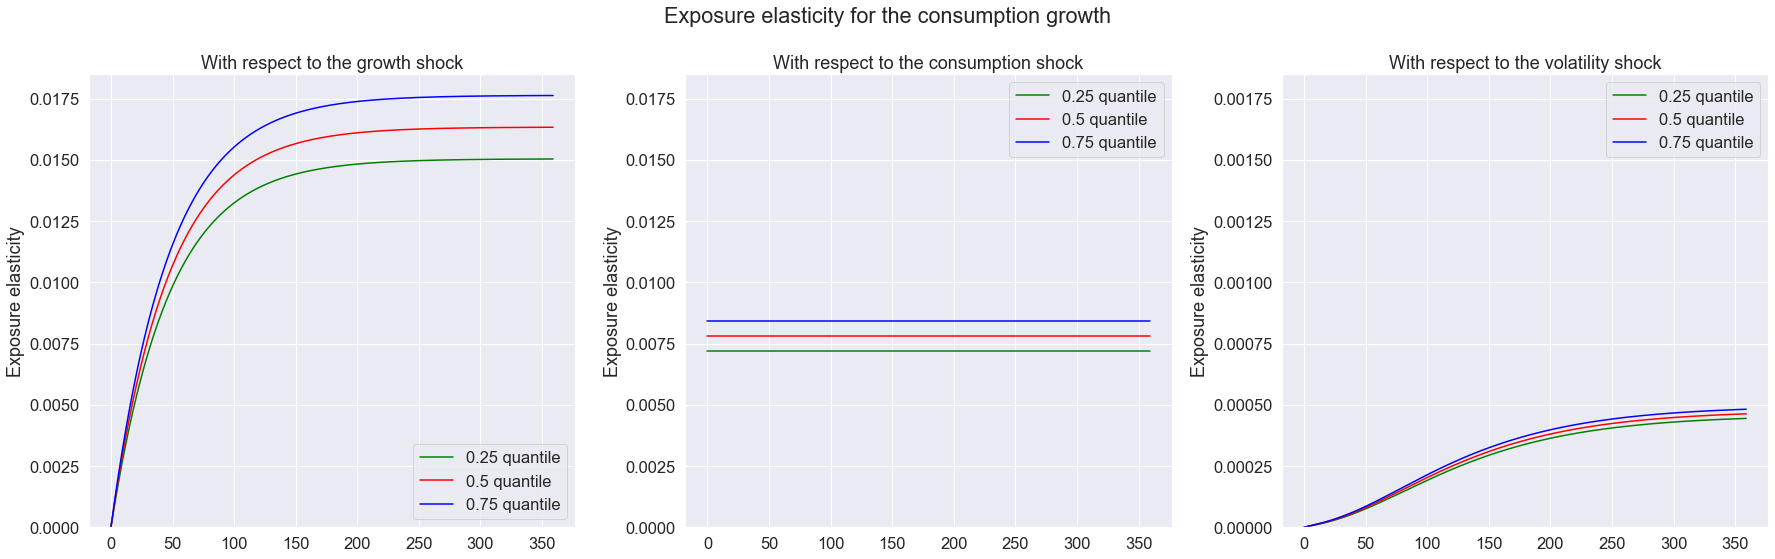

In [9]:
# Load the consumption and state evolution process 
gc_tp1 = res_015['gc_tp1']
X1_tp1 = res_015['X1_tp1']
X2_tp1 = res_015['X2_tp1']

## Calculate exposure elasticity for consumption growth
expo_elas_shock_0_015 = [exposure_elasticity(gc_tp1, X1_tp1, X2_tp1, T, shock=0, percentile=p) for p in quantile] # The first shock is the growth shock
expo_elas_shock_1_015 = [exposure_elasticity(gc_tp1, X1_tp1, X2_tp1, T, shock=1, percentile=p) for p in quantile] # The second shock is the volatility shock
expo_elas_shock_2_015 = [exposure_elasticity(gc_tp1, X1_tp1, X2_tp1, T, shock=2, percentile=p) for p in quantile] # The third shock is the consumption shock

## Plot the exposure elasticity for consumption growth
index = ['T','0.25 quantile','0.5 quantile','0.75 quantile']
fig, axes = plt.subplots(1,3, figsize = (25,8))
expo_elas_shock_0 = pd.DataFrame([np.arange(T),expo_elas_shock_0_015[0].flatten(),expo_elas_shock_0_015[1].flatten(),expo_elas_shock_0_015[2].flatten()], index = index).T
expo_elas_shock_1 = pd.DataFrame([np.arange(T),expo_elas_shock_1_015[0].flatten(),expo_elas_shock_1_015[1].flatten(),expo_elas_shock_1_015[2].flatten()], index = index).T
expo_elas_shock_2 = pd.DataFrame([np.arange(T),expo_elas_shock_2_015[0].flatten(),expo_elas_shock_2_015[1].flatten(),expo_elas_shock_2_015[2].flatten()], index = index).T

n_qt = len(quantile)
plot_elas = [expo_elas_shock_0, expo_elas_shock_2, expo_elas_shock_1] # For illustration purpose, the consumption shock is plotted in the second column, the volatility shock is plotted in the third column
shock_name = ['growth shock', 'consumption shock', 'volatility shock']
qt = ['0.25 quantile','0.5 quantile','0.75 quantile']
colors = ['green','red','blue']

for i in range(len(plot_elas)):
    for j in range(n_qt):
        sns.lineplot(data = plot_elas[i],  x = 'T', y = qt[j], ax=axes[i], color = colors[j], label = qt[j])
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Exposure elasticity')
        axes[i].set_title('With respect to the ' + shock_name[i])
axes[2].set_ylim([0,0.00185])
axes[1].set_ylim([0,0.0185])
axes[0].set_ylim([0,0.0185])
fig.suptitle('Exposure elasticity for the consumption growth')
fig.tight_layout()
plt.show()

In [10]:
## Calculate exposure elasticity for consumption growth at the limit
log_f = LinQuadVar({'c': np.zeros((1,1))},gc_tp1.shape)
Qf_components_log_C, _, η_C, η_C_series = Q_mapping(gc_tp1, log_f, X1_tp1, X2_tp1, tol = 1e-7)
expo_elas_shock_0_015_limit = [exposure_elasticity(gc_tp1, X1_tp1, X2_tp1, len(η_C_series), shock=0, percentile=p)[-1].item() for p in quantile]
expo_elas_shock_1_015_limit = [exposure_elasticity(gc_tp1, X1_tp1, X2_tp1, len(η_C_series), shock=1, percentile=p)[-1].item() for p in quantile]
expo_elas_shock_2_015_limit = [exposure_elasticity(gc_tp1, X1_tp1, X2_tp1, len(η_C_series), shock=2, percentile=p)[-1].item() for p in quantile]
expo_limit = pd.DataFrame([expo_elas_shock_0_015_limit, expo_elas_shock_2_015_limit,expo_elas_shock_1_015_limit],\
            columns = ['0.25 quantile','0.5 quantile','0.75 quantile'],\
            index = ['Growth Shock','Consumption Shock','Volatility Shock']).T
expo_limit

,Growth Shock,Consumption Shock,Volatility Shock
0.25 quantile,0.015,0.00718,0.000458
0.5 quantile,0.0163,0.0078,0.000477
0.75 quantile,0.0176,0.00842,0.000496


# 3.2 Calculate Price Elasticity for Consumption Growth

Similarly, to calculate the price elasticity for consumption growth using the *price\_elasticity* defined above, we need additional inputs
- Log Stochastic Discount Factor

We construct the log SDF using equation (7), then input it into the function to calculate price elasticity. The code uses the following formula for the log SDF:

$$
\log S_{t+1}-\log S_t=\log \beta-\rho\left(\widehat{C}_{t+1}-\widehat{C}_t\right)+(\rho-1)\left(\widehat{V}_{t+1}-\widehat{R}_t\right)+\log N_{t+1}^*\tag{7}
$$
where
$$
\log N_{t+1}^*= (1-\gamma)\left(\widehat{V}_{t+1}-\widehat{R}_t\right)
$$

and $\left(\widehat{V}_{t+1}-\widehat{R}_t\right)$ is the logarithm of the risk adjustment continuation value. The random variable $N_{t+1}^*$ is positive and has expectation one conditioned on date $t$ information. It implies a substantively interesting change in the probablity measure.[^2]

[^2] We approximate the term $\frac{1}{1-\gamma}\log N_{t+1}^*$  differently than the $\left(\widehat{V}_{t+1}-\widehat{R}_t\right)$ in the $(\rho-1)\left(\widehat{V}_{t+1}-\widehat{R}_t\right)$ term.  We use an approximation of the former term that ensures $N_{t+1}^*$ is positive and has conditional expectation one.  

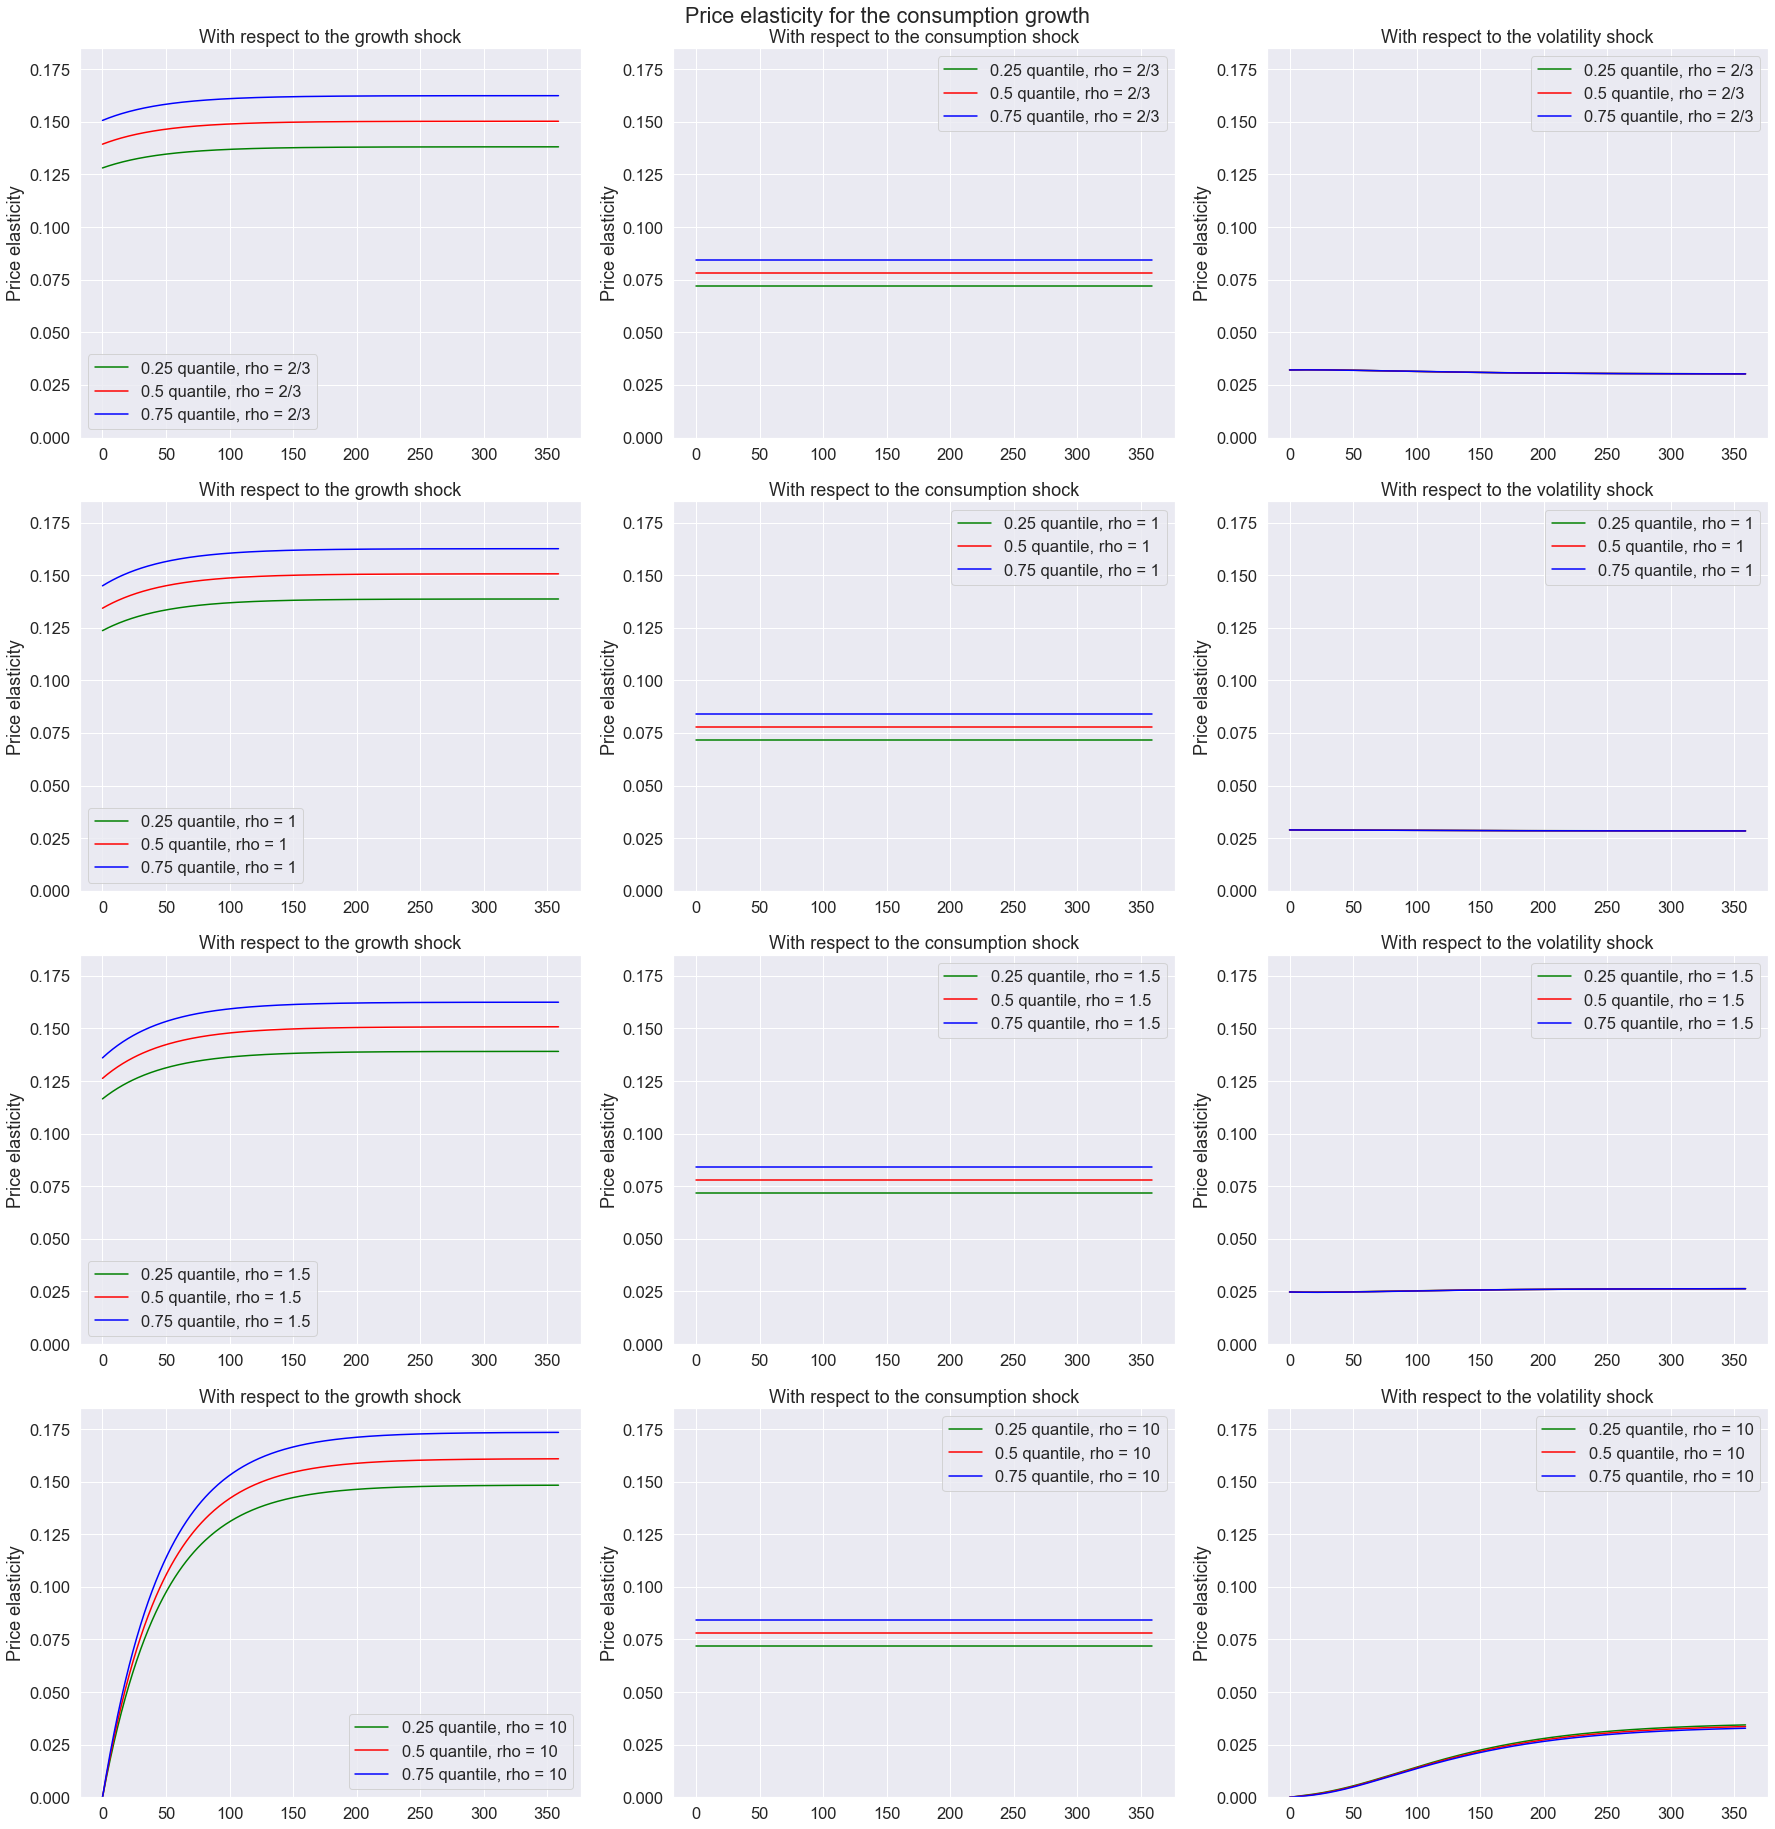

In [11]:
def calc_SDF(res):
    r'''
    This function loads external results for the long-run risk model with different rho values, and then calculates the SDF.

    Parameters
    ----------
    res : dictionary of LinQuadVar
        Stores the external solution for the long-run risk model

    Returns
    -------
    log_SDF : LinQuadVar
        Stores coefficients of the log SDF
    gc_tp1 : LinQuadVar
        Stores the coefficients of the consumption growth process.
    X1_tp1 : LinQuadVar
        Stores the coefficients of the first order expansion of the state evolution equations.
    X2_tp1 : LinQuadVar
        Stores the coefficients of the second order expansion of the state evolution equations.
    '''
    n_J, n_X, n_W = res['var_shape']
    β = res['β']
    ρ = res['ρ']

    X1_tp1 = res['X1_tp1']
    X2_tp1 = res['X2_tp1']

    gc_tp1 = res['gc_tp1']
    gc0_tp1 = res['gc0_tp1']
    gc1_tp1 = res['gc1_tp1']
    gc2_tp1 = res['gc2_tp1']

    vmr1_tp1 = res['vmr1_tp1']
    vmr2_tp1 = res['vmr2_tp1']
    log_N_tilde = res['log_N_tilde']

    S0_tp1 = LinQuadVar({'c':np.log(β) - ρ*np.array([[gc0_tp1]])}, shape = (1,n_X,n_W))
    S1_tp1 = (ρ-1)*vmr1_tp1 -ρ*gc1_tp1
    S2_tp1 = (ρ-1)*vmr2_tp1 -ρ*gc2_tp1

    log_SDF = S0_tp1 + S1_tp1 + 0.5 *S2_tp1 + log_N_tilde

    return log_SDF, gc_tp1, X1_tp1, X2_tp1

## Calculate the log SDF when ρ = 2/3
log_SDF, gc_tp1, X1_tp1, X2_tp1 = calc_SDF(res_006)

## Calculate price elasticity for consumption growth when ρ = 2/3
price_elas_shock_0_006 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=0, percentile=p) for p in quantile]
price_elas_shock_1_006 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=1, percentile=p) for p in quantile]
price_elas_shock_2_006 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=2, percentile=p) for p in quantile]

## Calculate the log SDF when ρ = 1
log_SDF, gc_tp1, X1_tp1, X2_tp1 = calc_SDF(res_010)

## Calculate price elasticity for consumption growth when ρ = 1
price_elas_shock_0_010 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=0, percentile=p) for p in quantile]
price_elas_shock_1_010 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=1, percentile=p) for p in quantile]
price_elas_shock_2_010 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=2, percentile=p) for p in quantile]

## Calculate the log SDF when ρ = 1.5
log_SDF, gc_tp1, X1_tp1, X2_tp1 = calc_SDF(res_015)

## Calculate price elasticity for consumption growth when ρ = 1.5
price_elas_shock_0_015 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=0, percentile=p) for p in quantile]
price_elas_shock_1_015 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=1, percentile=p) for p in quantile]
price_elas_shock_2_015 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=2, percentile=p) for p in quantile]

## Calculate the log SDF when ρ = 10
log_SDF, gc_tp1, X1_tp1, X2_tp1 = calc_SDF(res_100)

## Calculate price elasticity for consumption growth when ρ = 10
price_elas_shock_0_100 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=0, percentile=p) for p in quantile]
price_elas_shock_1_100 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=1, percentile=p) for p in quantile]
price_elas_shock_2_100 = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=2, percentile=p) for p in quantile]

## Plot the price elasticity for consumption growth
fig, axes = plt.subplots(4,3, figsize = (25,26))
index = ['T','rho 006 0.25 quantile','rho 006 0.5 quantile','rho 006 0.75 quantile','rho 010 0.25 quantile','rho 010 0.5 quantile','rho 010 0.75 quantile',\
                              'rho 015 0.25 quantile','rho 015 0.5 quantile','rho 015 0.75 quantile','rho 100 0.25 quantile','rho 100 0.5 quantile','rho 100 0.75 quantile']
price_elas_shock_0 = pd.DataFrame([np.arange(T),price_elas_shock_0_006[0].flatten(),price_elas_shock_0_006[1].flatten(),price_elas_shock_0_006[2].flatten(),\
                                                price_elas_shock_0_010[0].flatten(),price_elas_shock_0_010[1].flatten(),price_elas_shock_0_010[2].flatten(),\
                                                price_elas_shock_0_015[0].flatten(),price_elas_shock_0_015[1].flatten(),price_elas_shock_0_015[2].flatten(),\
                                                price_elas_shock_0_100[0].flatten(),price_elas_shock_0_100[1].flatten(),price_elas_shock_0_100[2].flatten()],index = index).T
price_elas_shock_1 = pd.DataFrame([np.arange(T),-price_elas_shock_1_006[0].flatten(),-price_elas_shock_1_006[1].flatten(),-price_elas_shock_1_006[2].flatten(),\
                                               -price_elas_shock_1_010[0].flatten(),-price_elas_shock_1_010[1].flatten(),-price_elas_shock_1_010[2].flatten(),\
                                                -price_elas_shock_1_015[0].flatten(),-price_elas_shock_1_015[1].flatten(),-price_elas_shock_1_015[2].flatten(),\
                                               -price_elas_shock_1_100[0].flatten(),-price_elas_shock_1_100[1].flatten(),-price_elas_shock_1_100[2].flatten()],index = index).T
price_elas_shock_2 = pd.DataFrame([np.arange(T),price_elas_shock_2_006[0].flatten(),price_elas_shock_2_006[1].flatten(),price_elas_shock_2_006[2].flatten(),\
                                               price_elas_shock_2_010[0].flatten(),price_elas_shock_2_010[1].flatten(),price_elas_shock_2_010[2].flatten(),\
                                                price_elas_shock_2_015[0].flatten(),price_elas_shock_2_015[1].flatten(),price_elas_shock_2_015[2].flatten(),\
                                               price_elas_shock_2_100[0].flatten(),price_elas_shock_2_100[1].flatten(),price_elas_shock_2_100[2].flatten()],index = index).T
n_rho = 4
n_qt = len(quantile)
plot_elas = [price_elas_shock_0,price_elas_shock_2,price_elas_shock_1]
shock_name = ['growth shock', 'consumption shock', 'volatility shock']
rho_y = ['rho 006', 'rho 010', 'rho 015', 'rho 100']
rho_label = ['rho = 2/3','rho = 1','rho = 1.5','rho = 10']
qt = ['0.25 quantile','0.5 quantile','0.75 quantile']
colors = ['green','red','blue']

for k in range(len(plot_elas)):
    for i in range(n_rho):
        for j in range(n_qt):
            sns.lineplot(data = plot_elas[k],  x = 'T', y = rho_y[i] +' ' + qt[j], ax=axes[i,k], color = colors[j], label = qt[j]+', '+rho_label[i])
            axes[i,k].set_xlabel('')
            axes[i,k].set_ylabel('Price elasticity')
            axes[i,k].set_ylim([0,0.185])
            axes[i,k].set_title('With respect to the '+ shock_name[k])

fig.suptitle('Price elasticity for the consumption growth')
fig.tight_layout()
plt.show()

## 3.3 Shock Elasticities under Different Parameter Settings

Below is a brief UI to select parameters shown in the long-run risk model [1]. The stochastic volatility process has been normalized with its mean equal to 1. By changing the inputs of parameters, we can see how shock elasticities vary with respect to these parameters.

In [12]:
from ipywidgets import interact
from BY_example_sol import solve_BY_elas

interact(solve_BY_elas, γ=[('5',5), ('10',10),('15',15),('20',20)],\
                        β=[('0.995',0.995),('0.998',0.998), ('0.999',0.999)],\
                        ρ=[('2/3', 2./3),('1', 1.0001),('1.5', 1.5),('10', 10)],\
                        α=[('0.969',0.969),('0.979',0.979),('0.989',0.989)],\
                        ϕ_e=[('0.0002',0.0002),('0.0003432',0.0003432),('0.0004',0.0004)],\
                        ν_1=[('0.977',0.977),('0.987',0.987),('0.997',0.997)],\
                        σ_w=[('0.03',0.03),('0.0378',0.0378),('0.04',0.04)],\
                        μ=[('0.0005', 0.0005),('0.0015', 0.0015),('0.003',0.003)],\
                        ϕ_c=[('0.002',0.002),('0.0078',0.0078),('0.01',0.01)]);

interactive(children=(Dropdown(description='γ', index=1, options=(('5', 5), ('10', 10), ('15', 15), ('20', 20)…

# Reference

[1], Bansal, Ravi, and Amir Yaron. "Risks for the long run: A potential resolution of asset pricing puzzles." The journal of Finance 59, no. 4 (2004): 1481-1509.

[2], Borovička, Jaroslav, and Lars Peter Hansen. "Term structure of uncertainty in the macroeconomy." In Handbook of Macroeconomics, vol. 2, pp. 1641-1696. Elsevier, 2016.

[3], Borovička, Jaroslav, and Lars Peter Hansen. "Examining macroeconomic models through the lens of asset pricing." Journal of Econometrics 183, no. 1 (2014): 67-90.

[4], Lombardo, Giovanni, and Harald Uhlig. "A theory of pruning." International Economic Review 59, no. 4 (2018): 1825-1836.